# Climate modeling with Keras
This notebook illustrates the process of creating simple neural network models using the Keras framework, processing data for input to the models for training and prediction, using a scikit-learn Pipeline, and the use of numpy and xarray for data wrangling and I/O with datasets contained within NetCDF files. 

#### Specify NetCDF files used for training and prediciton inputs
These are low resolution versions of NCAR CAM inputs/outputs, located in the `example_data` directory of this project's git repository.

In [3]:
data_dir = "/home/james/git/climate_learn/example_data"
result_dir = "/home/james/data/test/climate_learn"

# files used as feature inputs for model training
netcdf_features_train = data_dir + "/fv091x180L26_moist_HS.cam.h0.2001-01-11-00000_lowres.nc"

# files used as label inputs for model training
netcdf_labels_train = data_dir + "/fv091x180L26_moist_HS.cam.h1.2001-01-11-00000_lowres.nc"

### Load datasets for training and prediction

We'll define a function to extract an array of variable(s) for a single level from an xarray DataSet, and another to extract both features and labels from NetCDF.

In [9]:
import numpy as np
import xarray as xr

def extract_data_array(dataset,
                       variables,
                       lev):

    # allocate the array
    arr = np.empty(shape=[dataset.time.size, 
                          dataset.lat.size, 
                          dataset.lon.size, 
                          len(variables)],
                   dtype=np.float64)
    
    # for each variable we'll extract the values 
    for var_index, var in enumerate(variables):

        # if we have (time, lev, lat, lon), then use level parameter
        dimensions = dataset.variables[var].dims
        if dimensions == ('time', 'lev', 'lat', 'lon'):
            values = dataset[var].values[:, lev, :, :]
        elif dimensions == ('time', 'lat', 'lon'):
            values = dataset[var].values[:, :, :]
        else:
            raise ValueError("Unsupported variable dimensions: {dims}".format(dims=dimensions))

        # add the values into the array at the variable's position
        arr[:, :, :, var_index] = values
    
    return arr
    
    
def extract_features_labels(netdcf_features, 
                            netcdf_labels,
                            feature_vars,
                            label_vars,
                            level=0):
    """
    Extracts feature and label data from specified NetCDF files for a single level as numpy arrays.
    
    The feature and label NetCDFs are expected to have matching time, level, lat, and lon coordinate variables.
    
    Returns two arrays: the first for features and the second for labels. Arrays will have shape (time, lat, lon, var),
    where var is the number of feature or label variables. For example if the dimensions of feature data variables in 
    the NetCDF is (time: 360, lev: 26, lat: 120, lon: 180) and the features specified are ["T", "U"] then the resulting
    features array will have shape (360, 120, 180, 2), with the first feature variable "T" corresponding to array[:, :, :, 0]
    and the second feature variable "U" corresponding to array[:, :, :, 1].
    
    :param netdcf_features: one or more NetCDF files containing feature variables, can be single file or list
    :param netdcf_features: one or more NetCDF files containing label variables, can be single file or list
    :param feature_vars: list of feature variable names to be extracted from the features NetCDF
    :param label_vars: list of label variable names to be extracted from the labels NetCDF
    :param level: index of the level to be extracted (all times/lats/lons at this level for each feature/label variable)
    :return: two 4-D numpy arrays, the first for features and the second for labels
    """
    
    # open the features (flows) and labels (tendencies) as xarray DataSets
    ds_features = xr.open_mfdataset(paths=netdcf_features)
    ds_labels = xr.open_mfdataset(paths=netcdf_labels)

    # confirm that we have datasets that match on the time, lev, lat, and lon dimension/coordinate
    if np.any(ds_features.variables['time'].values != ds_labels.variables['time'].values):
        raise ValueError('Non-matching time values between feature and label datasets')
    if np.any(ds_features.variables['lev'].values != ds_labels.variables['lev'].values):
        raise ValueError('Non-matching level values between feature and label datasets')
    if np.any(ds_features.variables['lat'].values != ds_labels.variables['lat'].values):
        raise ValueError('Non-matching lat values between feature and label datasets')
    if np.any(ds_features.variables['lon'].values != ds_labels.variables['lon'].values):
        raise ValueError('Non-matching lon values between feature and label datasets')

    # extract feature and label arrays at the specified level
    array_features = extract_data_array(ds_features, feature_vars, level)
    array_labels = extract_data_array(ds_labels, label_vars, level)
    
    return array_features, array_labels

#### Declare the variables that will be used as features and labels for training and prediction
The feature variables being used are 'PS', 'T', 'U', and 'V'. The label variable is 'PTTEND'.

In [5]:
features = ["PS", "T", "U", "V"]
labels = ["PTTEND"]

#### Load datsets
Read NetCDF files to load feature and label datasets that will be used for training.

All files should share the same time, level, lat, and lon coordinates, with each file's feature or label variables having shape (times, levels, lats, lons).

In [11]:
train_x, train_y = extract_features_labels(netcdf_features_train,
                                           netcdf_labels_train,
                                           features,
                                           labels,
                                           level=0)

#### Get data dimensions
Get the dimension sizes of our datasets for later use.

In [12]:
size_times_train = train_x.shape[0]
size_times_predict = predict_x.shape[0]
size_lat = train_x.shape[1]
size_lon = train_x.shape[2]
size_lev = xr.open_dataset(netcdf_features_predict[0]).lev.size

### Custom Transformer

Neural network models work much better if all values are scaled into a range such as between 0 and 1. For this purpose we'll use scikit-learn's MinMaxScaler for now within a custom Scaler class that can be used within a scikit-lean Pipeline.

In [14]:
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler

class Scaler(TransformerMixin):

    def __init__(self, features):

        # initialize an ordered dict to store scalers for each feature
        self.scalers = OrderedDict().fromkeys(features, MinMaxScaler(feature_range=(0, 1)))

    def transform(self, values):
        """
        Transforms a 4-D array of values, expected to have shape:
        (times, lats, lons, vars).

        :param values:
        :return:
        """

        # make new arrays to contain the scaled values we'll return
        scaled_features = np.empty(shape=values.shape)

        # data is 4-D with shape (times, lats, lons, vars), scalers can only
        # work on 2-D arrays, so for each variable we scale the corresponding
        # 3-D array of values after flattening it, then reshape back into
        # the original shape
        var_ix = 0
        for variable, scaler in self.scalers.items():
            variable = values[:, :, :, var_ix].flatten().reshape(-1, 1)
            scaled_feature = scaler.fit_transform(variable)
            reshaped_scaled_feature = np.reshape(scaled_feature,
                                                 newshape=(values.shape[0],
                                                           values.shape[1],
                                                           values.shape[2]))
            scaled_features[:, :, :, var_ix] = reshaped_scaled_feature
            var_ix += 1

        # return the scaled values (the scalers have been fitted to the data)
        return scaled_features

    def fit(self, x=None):

        return self


### Define Keras models to use for prediciton
We'll define two neural network models using the Keras library with TensorFlow as its backend. One of these models will contain only simple densely connected layers, and another will contain a both convolutional layer and a densely connected layer. We'll use both of these for prediction of labels corresponding to the results of NCAR CAM model runs involving computation of the Held-Suarez test case. Initially we'll focus on the input feature variables PS, T, U, and V and the output label PTTEND.

#### Dense layer-only model definition

In [16]:
from keras.models import Sequential
from keras.layers import Dense

# define the model
dense_model = Sequential()

# add a fully-connected hidden layer with the same number of neurons as input attributes (features)
dense_model.add(Dense(len(features), input_dim=len(features), activation='relu'))

# add a fully-connected hidden layer with the twice the number of neurons as input attributes (features)
dense_model.add(Dense(len(features) * 2, activation='relu'))

# output layer uses no activation function since we are interested
# in predicting numerical values directly without transform
dense_model.add(Dense(len(labels)))

# compile the model using the ADAM optimization algorithm and a mean squared error loss function
dense_model.compile(optimizer='adam', loss='mse')

# display some summary information
dense_model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 69
Trainable params: 69
Non-trainable params: 0
_________________________________________________________________


##### Convolutional layer model definition

In [17]:
from keras.models import Sequential
from keras.layers import Conv3D, Dense

# define the model
cnn_model = Sequential()

# add an initial 3-D convolutional layer
cnn_model.add(Conv3D(filters=32,
                     kernel_size=(3, 3, 3),
                     activation="relu",
                     data_format="channels_last",
                     input_shape=(size_times_train, size_lat, size_lon, len(features)),
                     padding='same'))

# add a fully-connected hidden layer with twice the number of neurons as input attributes (features)
cnn_model.add(Dense(len(features) * 2, activation='relu'))

# output layer uses no activation function since we are interested
# in predicting numerical values directly without transform
cnn_model.add(Dense(len(labels)))

# compile the model using the ADAM optimization algorithm and a mean squared error loss function
cnn_model.compile(optimizer='adam', loss='mse')

# display some summary information
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 720, 12, 23, 32)   3488      
_________________________________________________________________
dense_4 (Dense)              (None, 720, 12, 23, 8)    264       
_________________________________________________________________
dense_5 (Dense)              (None, 720, 12, 23, 1)    9         
Total params: 3,761
Trainable params: 3,761
Non-trainable params: 0
_________________________________________________________________


#### Reshape data for input to convolutional model

The convolutional neural network model we've defined above will expect input data arrays to have shape (1, times, lats, lons, features) so we'll reshape the training and prediction input arrays using `numpy.reshape()`.

In [19]:
shape_x = (1, ) + scaled_train_x.shape
shape_y = (1, ) + scaled_train_y.shape
train_x_cnn = np.reshape(scaled_train_x, newshape=shape_x)
train_y_cnn = np.reshape(scaled_train_y, newshape=shape_y)
predict_x_cnn = np.reshape(scaled_predict_x, newshape=shape_x)

### Verify the CNN model
We'll now train the convolutional neural network model using the first level of data from the dataset, to confirm that the model is working as expected in terms of being able to perform training to our input data.

In [21]:
cnn_model.fit(train_x_cnn, train_y_cnn, shuffle=True, epochs=3, verbose=2)

Epoch 1/3
 - 4s - loss: 0.0377
Epoch 2/3
 - 4s - loss: 0.0350
Epoch 3/3
 - 4s - loss: 0.0351


#### Reshape data for dense model input
The dense layer neural network model we've defined above will expect input data arrays to have shape (times * lats * lons, features) so we'll reshape the training and prediction input arrays using `numpy.reshape()`.

In [22]:
shape_x = (size_times_train * size_lat * size_lon, len(features))
shape_y = (size_times_train * size_lat * size_lon, len(labels))
train_x_dense = np.reshape(scaled_train_x, newshape=shape_x)
train_y_dense = np.reshape(scaled_train_y, newshape=shape_y)
predict_x_dense = np.reshape(scaled_predict_x, newshape=shape_x)

### Verify the dense layers model
We'll now train the dense layers neural network model using the first level of data from the dataset, to confirm that the model is working as expected in terms of being able to perform training to our input data.

In [27]:
dense_model.fit(train_x_dense, train_y_dense, shuffle=True, epochs=3, verbose=2)

Epoch 1/3
 - 10s - loss: 1.7229e-07
Epoch 2/3
 - 9s - loss: 1.7222e-07
Epoch 3/3
 - 7s - loss: 1.7521e-07


## Pipeline testing
Create and use a scikit-learn Pipeline for fitting, prediction, and parameter scoring.

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(features, labels)

pipeline = Pipeline(steps=[
    ('scaler', Scaler(args.feature_names)),
    ('model', create_dense_model()),
])

pipeline.fit(X_train, y_train)
print('Testing score: ', pipeline.score(X_test, y_test))
y_predict = pipeline.predict(X_test)

param_to_test_0 = np.arange(1, 11)
param_to_test_1 = 2.0 ** np.arange(-6, +6)
params = {'param_0': param_to_test_0,
          'param_1': param_to_test_1}
grid_search = GridSearchCV(pipeline, params, verbose=1).fit(X_train, y_train)
print('Final score is: ', grid_search.score(X_test, y_test))

#### Allocate arrays to contain predicted values

In [29]:
prediction_cnn = np.empty(shape=(size_times_predict, size_lev, size_lat, size_lon))
prediction_dense = np.empty(shape=(size_times_predict, size_lev, size_lat, size_lon))

### Perform prediction using the fitted models
Below we'll perform predictions using the fitted models to confirm that they are properly setup for this operation.

In [31]:
predict_y_scaled_cnn = cnn_model.predict(predict_x_cnn, verbose=1)
predict_y_scaled_dense = dense_model.predict(predict_x_dense, verbose=1)

198720/198720 [==============================] - 4s 19us/step


##### Display some attributes of the predicted values
We'll get some attributes of the predicted arrays to demonstrate that the models produced expected results.

In [32]:
print("CNN model's prediction array shape: {shape}".format(shape=predict_y_scaled_cnn.shape))
print("Dense model's prediction array shape: {shape}".format(shape=predict_y_scaled_dense.shape))

CNN model's prediction array shape: (1, 720, 12, 23, 1)
Dense model's prediction array shape: (198720, 1)


In [ ]:
    X_train, X_test, y_train, y_test = train_test_split(features, labels)

    pipeline = Pipeline(steps=[
        ('scaler', Scaler(args.feature_names)),
        ('model', create_dense_model()),
    ])

    pipeline.fit(X_train, y_train)
    print('Testing score: ', pipeline.score(X_test, y_test))
    y_predict = pipeline.predict(X_test)

    param_to_test_0 = np.arange(1, 11)
    param_to_test_1 = 2.0 ** np.arange(-6, +6)
    params = {'param_0': param_to_test_0,
              'param_1': param_to_test_1}
    grid_search = GridSearchCV(pipeline, params, verbose=1).fit(X_train, y_train)
    print('Final score is: ', grid_search.score(X_test, y_test))


### Prediction loop
We'll loop over each level, taking data for the full grid at that level (all time steps) and training the model with those feature and labels. We'll then use the fitted model to predict label values for the level using input feature values from a different time series. 

In [33]:
# loop over all levels
for lev in range(size_lev):
    
    print("Training/predicting for level {level}".format(level=lev))
    
    # get the features and labels for training
    train_x, train_y = extract_features_labels(netcdf_features_train[0],
                                               netcdf_labels_train[0],
                                               features,
                                               labels,
                                               lev)
    
    # get the features for prediction
    predict_x = extract_data_array(xr.open_dataset(netcdf_features_predict[0]),
                                   features,
                                   lev)

    # scale the data between 0 and 1
    scalers_x = [MinMaxScaler(feature_range=(0, 1))] * len(features)
    scalers_y = [MinMaxScaler(feature_range=(0, 1))] * len(labels)
    scaled_train_x, scaled_predict_x, scaled_train_y, scalers_x, scalers_y = \
        scale_4d(train_x, predict_x, train_y, scalers_x, scalers_y)
    
    # reshape the data for convolutional model input
    shape_x = (1, ) + scaled_train_x.shape
    shape_y = (1, ) + scaled_train_y.shape
    train_x_cnn = np.reshape(scaled_train_x, newshape=shape_x)
    train_y_cnn = np.reshape(scaled_train_y, newshape=shape_y)
    predict_x_cnn = np.reshape(scaled_predict_x, newshape=shape_x)
    
    # reshape the data for dense layer model input
    shape_x = (size_times_train * size_lat * size_lon, len(features))
    shape_y = (size_times_train * size_lat * size_lon, len(labels))
    train_x_dense = np.reshape(scaled_train_x, newshape=shape_x)
    train_y_dense = np.reshape(scaled_train_y, newshape=shape_y)
    predict_x_dense = np.reshape(scaled_predict_x, newshape=shape_x)
    
    # train the models
    cnn_model.fit(train_x_cnn, train_y_cnn, shuffle=True, epochs=3, verbose=2)
    dense_model.fit(train_x_dense, train_y_dense, shuffle=True, epochs=3, verbose=2)
    
    # use the fitted models to make predictions
    predict_y_scaled_cnn = cnn_model.predict(predict_x_cnn, verbose=1)
    predict_y_scaled_dense = dense_model.predict(predict_x_dense, verbose=1)

    # reverse the scaling of the predicted values
    # TODO below assumes a single label, will need modification for multiple labels
    scaler = scalers_y[0]  # assumes the label scaler was fitted in scale_4d() and side effect carried through
        
    # output from the dense model is 2-D, good for scaler input
    unscaled_predict_y_dense = scaler.inverse_transform(predict_y_scaled_dense)
        
    # output from CNN model is 5-D, so we'll flatten first to make it amenable to scaling
    unscaled_predict_y_cnn = scaler.inverse_transform(predict_y_scaled_cnn.flatten().reshape(-1, 1))
    
    # reshape data so it's compatible with assignment into prediction arrays
    level_shape = (size_times_predict, size_lat, size_lon)
    prediction_cnn[:, lev, :, :] = np.reshape(unscaled_predict_y_cnn, newshape=level_shape)
    prediction_dense[:, lev, :, :] = np.reshape(unscaled_predict_y_dense, newshape=level_shape)

Training/predicting for level 0
Epoch 1/3
 - 5s - loss: 0.0368
Epoch 2/3
 - 4s - loss: 0.0384
Epoch 3/3
 - 4s - loss: 0.0391
Epoch 1/3
 - 8s - loss: 1.6340e-07
Epoch 2/3
 - 7s - loss: 1.6436e-07
Epoch 3/3
 - 7s - loss: 1.6870e-07
198720/198720 [==============================] - 4s 18us/step
Training/predicting for level 1
Epoch 1/3
 - 4s - loss: 0.0576
Epoch 2/3
 - 4s - loss: 0.0569
Epoch 3/3
 - 4s - loss: 0.0557
Epoch 1/3
 - 7s - loss: 2.1017e-07
Epoch 2/3
 - 9s - loss: 1.7951e-07
Epoch 3/3


### Output of predicted values as NetCDF
At this point the entire dataset has been predicted and the predicted values are in arrays that we can add to an xarray DataSet that we'll then write as NetCDF. We will first make a copy of the prediction features dataset since this has all the coordinate variables and attributes we'll want in the predicted labels dataset, we'll then remove all data variables before adding the predicted values arrays as new variables to the dataset.

In [26]:
# copy the prediction features dataset since the predicted label(s) should share the same coordinates, etc.
ds_predict_labels = xr.open_dataset(data_dir + "/fv091x180L26_moist_HS.cam.h1.2001-02-25-00000_lowres.nc")

# remove all non-label data variables from the predictions dataset
for var in ds_predict_labels.data_vars:
    if var not in labels:
        ds_predict_labels = ds_predict_labels.drop(var)

# create new variables to contain the predicted labels, assign these into the prediction dataset
predicted_label_var = xr.Variable(dims=('time', 'lev', 'lat', 'lon'),
                                  data=prediction_cnn,
                                  attrs=ds_predict_labels[labels[0]].attrs)
ds_predict_labels[labels[0] + "_cnn"] = predicted_label_var
predicted_label_var = xr.Variable(dims=('time', 'lev', 'lat', 'lon'),
                                  data=prediction_dense,
                                  attrs=ds_predict_labels[labels[0]].attrs)
ds_predict_labels[labels[0] + "_dense"] = predicted_label_var

##### Create variables to contain the differences between predicted values and those computed by NCAR CAM

In [28]:
# open the dataset containing the computed label values corresponding to the input features used for prediction
ds_cam_labels = xr.open_dataset(data_dir + "/fv091x180L26_moist_HS.cam.h1.2001-02-25-00000_lowres.nc")

# get the differences between computed and predicted values
pttend_diff_cnn = ds_cam_labels[labels[0]].values - prediction_cnn
pttend_diff_dense = ds_cam_labels[labels[0]].values - prediction_dense

# create the variables and add to the dataset
predicted_label_var = xr.Variable(dims=('time', 'lev', 'lat', 'lon'),
                                  data=pttend_diff_cnn,
                                  attrs=ds_predict_labels[labels[0]].attrs)
ds_predict_labels[labels[0] + "_cnn_diff"] = predicted_label_var
predicted_label_var = xr.Variable(dims=('time', 'lev', 'lat', 'lon'),
                                  data=pttend_diff_dense,
                                  attrs=ds_predict_labels[labels[0]].attrs)
ds_predict_labels[labels[0] + "_dense_diff"] = predicted_label_var


##### Output predicted dataset as NetCDF

In [29]:
# write the predicted label(s)' dataset as a NetCDF file
ds_predict_labels.to_netcdf(netcdf_predict[0])

#### Plot difference for various times/levels
We'll use xarray's simple plotting functions to illustrate some of the differences we see at various times and levels.

In [32]:
diff_dense = ds_predict_labels[labels[0] + "_dense_diff"].isel(time=0, lev=0)

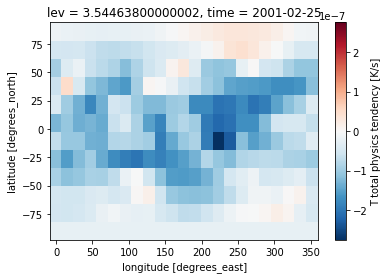

In [34]:
%matplotlib inline
diff_dense.plot()